In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
from keras.layers import Flatten
import math
from sklearn.metrics import mean_squared_error

In [2]:
# Some functions to help out with
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real Apple Stock Price')
    plt.plot(predicted, color='blue',label='Predicted Apple Stock Price')
    plt.title('Apple Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Apple Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [3]:
# First, we get the data
dataset = pd.read_csv('AAPL_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,10.34,10.68,10.32,10.68,201853036,AAPL
2006-01-04,10.73,10.85,10.64,10.71,155225609,AAPL
2006-01-05,10.69,10.70,10.54,10.63,112396081,AAPL
2006-01-06,10.75,10.96,10.65,10.90,176139334,AAPL
2006-01-09,10.96,11.03,10.82,10.86,168861224,AAPL


In [4]:
# Checking for missing values
training_set = dataset[:'2016'].iloc[:,1:2].values
test_set = dataset['2017':].iloc[:,1:2].values

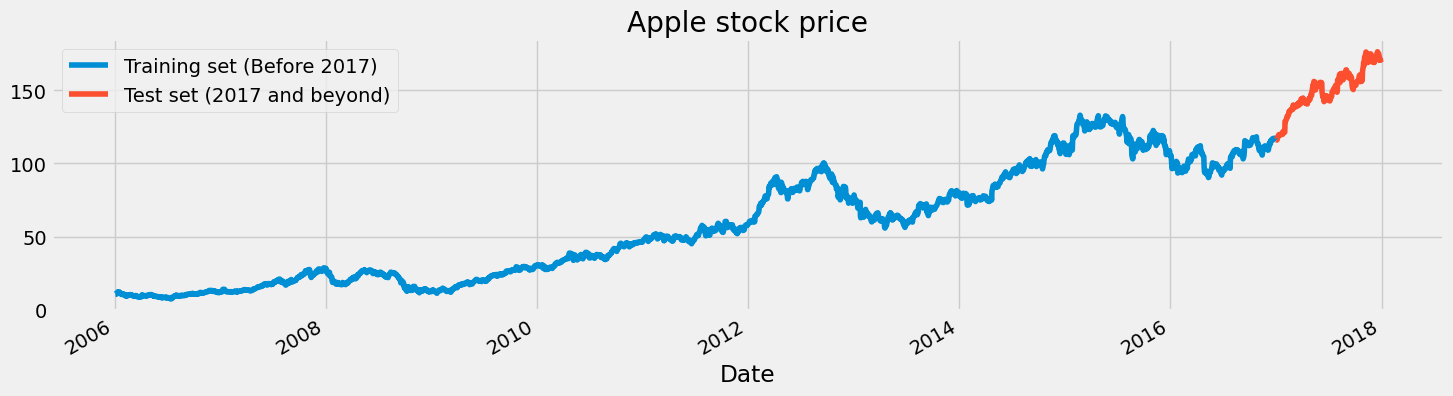

In [5]:
# We have chosen 'High' attribute for prices. Let's see what it looks like
dataset["Close"][:'2016'].plot(figsize=(16,4),legend=True)
dataset["Close"]['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('Apple stock price')
plt.show()

In [6]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [7]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 
X_train = []
y_train = []
for i in range(60,2768):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [8]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [9]:
def createModel(l1Nodes, l2Nodes, d1Nodes, d2Nodes, inputShape):
    # input layer
    lstm1 = LSTM(l1Nodes, input_shape=inputShape, return_sequences=True)
    lstm2 = LSTM(l2Nodes, return_sequences=True)
    flatten = Flatten()
    dense1 = Dense(d1Nodes)
    dense2 = Dense(d2Nodes)

    # output layer
    outL = Dense(1, activation='relu')
    # combine the layers
    layers = [lstm1, lstm2, flatten,  dense1, dense2, outL]
    # create the model
    model = Sequential(layers)
    opt = SGD(learning_rate=0.005)
    model.compile(optimizer=opt, loss='mse')
    return model

In [10]:
model = createModel(8, 8, 8, 4, (X_train.shape[1], X_train.shape[2]))
model.fit(X_train, y_train, batch_size=8, epochs=10)

Epoch 1/10
339/339 [==============================] - 5s 10ms/step - loss: 0.0209
Epoch 2/10
339/339 [==============================] - 4s 10ms/step - loss: 0.0022
Epoch 3/10
339/339 [==============================] - 4s 10ms/step - loss: 0.0020
Epoch 4/10
339/339 [==============================] - 4s 10ms/step - loss: 0.0020
Epoch 5/10
339/339 [==============================] - 4s 10ms/step - loss: 0.0019
Epoch 6/10
339/339 [==============================] - 4s 10ms/step - loss: 0.0019
Epoch 7/10
339/339 [==============================] - 4s 10ms/step - loss: 0.0018
Epoch 8/10
339/339 [==============================] - 4s 10ms/step - loss: 0.0018
Epoch 9/10
339/339 [==============================] - 4s 10ms/step - loss: 0.0017
Epoch 10/10
339/339 [==============================] - 4s 10ms/step - loss: 0.0017


In [11]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=10, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=10, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=10, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=10))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=10,batch_size=32)

Epoch 1/10
85/85 [==============================] - 4s 23ms/step - loss: 0.0217
Epoch 2/10
85/85 [==============================] - 2s 24ms/step - loss: 0.0096
Epoch 3/10
85/85 [==============================] - 2s 23ms/step - loss: 0.0085
Epoch 4/10
85/85 [==============================] - 2s 23ms/step - loss: 0.0075
Epoch 5/10
85/85 [==============================] - 2s 23ms/step - loss: 0.0070
Epoch 6/10
85/85 [==============================] - 2s 23ms/step - loss: 0.0061
Epoch 7/10
85/85 [==============================] - 2s 23ms/step - loss: 0.0060
Epoch 8/10
85/85 [==============================] - 2s 23ms/step - loss: 0.0052
Epoch 9/10
85/85 [==============================] - 2s 24ms/step - loss: 0.0050
Epoch 10/10
85/85 [==============================] - 2s 24ms/step - loss: 0.0052


In [12]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing
dataset_total = pd.concat((dataset["Close"][:'2016'],dataset["Close"]['2017':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [13]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

8/8 [==============================] - 1s 4ms/step


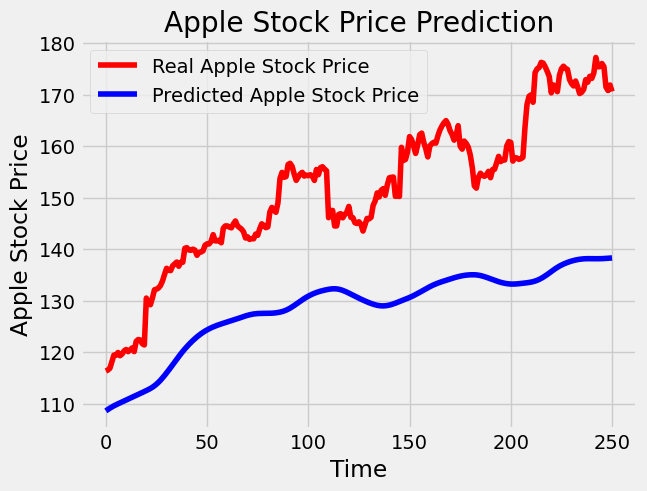

In [14]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

In [15]:
# Evaluating our model
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 24.236253031312486.


In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 8)             320       
                                                                 
 lstm_1 (LSTM)               (None, 60, 8)             544       
                                                                 
 flatten (Flatten)           (None, 480)               0         
                                                                 
 dense (Dense)               (None, 8)                 3848      
                                                                 
 dense_1 (Dense)             (None, 4)                 36        
                                                                 
 dense_2 (Dense)             (None, 1)                 5         
                                                                 
Total params: 4753 (18.57 KB)
Trainable params: 4753 (18

In [17]:
import shap
import time
import tensorflow as tf

shap.initjs()

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [18]:
features = dataset.columns
print(features)

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Name'], dtype='object')


In [21]:

explainer = shap.Explainer(model.predict, X_train)




In [22]:
shap_values = explainer.shap_values(X_test)

TypeError: 'numpy.ndarray' object is not callable

In [ ]:
features = ["Open", "High", "Low", "Close"]

In [ ]:
vanilla_lstm_ts1_model = tf.keras.models.load_model('LSTM Prediction model.h5')

print(vanilla_lstm_ts1_model)

vanilla_lstm_ts1_model.summary()

In [ ]:
start_time_vanilla = time.time()
shap_explainer_vanilla_lstm_ts1 = shap.DeepExplainer(vanilla_lstm_ts1_model, X_train)
shap_values_vanilla_lstm_ts1 = shap_explainer_vanilla_lstm_ts1.shap_values(X_test)
end_time_vanilla = time.time()
time_vanilla = end_time_vanilla - start_time_vanilla

#SHAP visualization
shap.initjs()
shap.force_plot(shap_explainer_vanilla_lstm_ts1.expected_value[0], shap_values_vanilla_lstm_ts1[0][0], features)